In [1]:
import os

from openai import AzureOpenAI

In [2]:
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_ENDPOINT"),
    api_key=os.getenv("AZURE_API_KEY"),
    api_version="2024-12-01-preview",
)

In [3]:
training_file_name = "../data/processed/train.jsonl"
validation_file_name = "../data/processed/val.jsonl"

# Upload the training and validation dataset files to Azure OpenAI with the SDK.

training_response = client.files.create(
    file=open(training_file_name, "rb"), purpose="fine-tune"
)
training_file_id = training_response.id

validation_response = client.files.create(
    file=open(validation_file_name, "rb"), purpose="fine-tune"
)
validation_file_id = validation_response.id

print("Training file ID:", training_file_id)
print("Validation file ID:", validation_file_id)

Training file ID: file-4555dbf85dad4c5bbf9ec34fe3bcea52
Validation file ID: file-c56b7fc48a324884b42e8cf548807536


In [ ]:
response = client.fine_tuning.jobs.create(
    training_file=training_file_id,
    validation_file=validation_file_id,
    model="gpt-4.1-mini-2025-04-14",  # Enter base model name. Note that in Azure OpenAI the model name contains dashes and cannot contain dot/period characters.
    seed=42,  # seed parameter controls reproducibility of the fine-tuning job. If no seed is specified one will be generated automatically.
    # hyperparameters={},
)

job_id = response.id

# You can use the job ID to monitor the status of the fine-tuning job.
# The fine-tuning job will take some time to start and complete.

print("Job ID:", response.id)
print("Status:", response.id)
print(response.model_dump_json(indent=2))

BadRequestError: Error code: 400 - {'error': {'code': 'invalidPayload', 'message': 'The specified base model does not support fine-tuning.'}}

In [4]:
from IPython.display import clear_output
import time

job_id = "ftjob-9e2dec8fc72c499da71bc5668f52a1be"

start_time = time.time()

# Get the status of our fine-tuning job.
response = client.fine_tuning.jobs.retrieve(job_id)

status = response.status

# If the job isn't done yet, poll it every 10 seconds.
while status not in ["succeeded", "failed"]:
    time.sleep(10)

    response = client.fine_tuning.jobs.retrieve(job_id)
    print(response.model_dump_json(indent=2))
    print(
        "Elapsed time: {} minutes {} seconds".format(
            int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)
        )
    )
    status = response.status
    print(f"Status: {status}")
    clear_output(wait=True)

print(f"Fine-tuning job {job_id} finished with status: {status}")

# List all fine-tuning jobs for this resource.
print("Checking other fine-tune jobs for this resource.")
response = client.fine_tuning.jobs.list()
print(f"Found {len(response.data)} fine-tune jobs.")

Fine-tuning job ftjob-9e2dec8fc72c499da71bc5668f52a1be finished with status: succeeded
Checking other fine-tune jobs for this resource.
Found 1 fine-tune jobs.


In [ ]:
# cancel_response = client.fine_tuning.jobs.cancel(fine_tuning_job_id=job_id)

# print("Cancelled fine-tuning job:")
# print(cancel_response.model_dump_json(indent=2))

Cancelled fine-tuning job:
{
  "id": "ftjob-0a289314369644ae8591cab38c34a7fd",
  "created_at": 1752980546,
  "error": null,
  "fine_tuned_model": null,
  "finished_at": 1752988289,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 2.0,
    "n_epochs": -1
  },
  "model": "gpt-4.1-mini-2025-04-14",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": null,
  "seed": 42,
  "status": "cancelled",
  "trained_tokens": null,
  "training_file": "file-a4293d48ea9d4478ad7a8070b3ea876e",
  "validation_file": "file-15d333044d394ab88b2832fda294c9a5",
  "estimated_finish": 1752981446,
  "integrations": null,
  "metadata": null,
  "method": null
}


In [5]:
checkpoints = client.fine_tuning.jobs.checkpoints.list(job_id)
print(checkpoints.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "ftchkpt-f94a286beb674c3c9a5eb7d5228b690c",
      "created_at": 1752993340,
      "fine_tuned_model_checkpoint": "gpt-4.1-mini-2025-04-14.ft-9e2dec8fc72c499da71bc5668f52a1be-001",
      "fine_tuning_job_id": "ftjob-9e2dec8fc72c499da71bc5668f52a1be",
      "metrics": {
        "full_valid_loss": 0.09915062463308082,
        "full_valid_mean_token_accuracy": 0.9651880965749579,
        "step": 1603.0,
        "train_loss": 0.0035648345947265625,
        "train_mean_token_accuracy": 1.0,
        "valid_loss": 0.014328066507975261,
        "valid_mean_token_accuracy": 1.0
      },
      "object": "fine_tuning.job.checkpoint",
      "step_number": 1603
    }
  ],
  "has_more": false,
  "object": "list"
}


In [6]:
response = client.fine_tuning.jobs.retrieve(job_id)
if response.status == "succeeded":
    result_file_id = response.result_files[0]

retrieve = client.files.retrieve(result_file_id)

# Download the result file.
print(f"Downloading result file: {result_file_id}")

with open(f"../models/gpt-4.1/{retrieve.filename}", "wb") as file:
    result = client.files.content(result_file_id).read()
    file.write(result)

In [9]:
import pandas as pd

result_df = pd.read_csv(f"../models/gpt-4.1/{retrieve.filename}")

In [11]:
result_df.tail()

,step,train_loss,train_mean_token_accuracy,train_error_rate,valid_loss,valid_mean_token_accuracy,valid_error_rate,full_valid_loss,full_valid_mean_token_accuracy,full_valid_error_rate,timestamp
1598,1599,0.027656,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-20T06:30:26.3620000Z
1599,1600,0.065968,0.966667,NaN,0.086681,0.966667,NaN,NaN,NaN,NaN,2025-07-20T06:30:32.7000000Z
1600,1601,0.116470,0.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-20T06:30:34.6100000Z
1601,1602,0.200363,0.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-20T06:30:35.7390000Z
1602,1603,0.003565,1.000000,NaN,0.014328,1.000000,NaN,0.099151,0.965188,NaN,2025-07-20T06:35:40.5200000Z


In [12]:
result_df.columns

Index(['step', 'train_loss', 'train_mean_token_accuracy', 'train_error_rate',
       'valid_loss', 'valid_mean_token_accuracy', 'valid_error_rate',
       'full_valid_loss', 'full_valid_mean_token_accuracy',
       'full_valid_error_rate', 'timestamp'],
      dtype='object')

In [16]:
result_df.isna().sum()

step                                 0
train_loss                           0
train_mean_token_accuracy            0
train_error_rate                  1603
valid_loss                        1586
valid_mean_token_accuracy         1586
valid_error_rate                  1603
full_valid_loss                   1602
full_valid_mean_token_accuracy    1602
full_valid_error_rate             1603
timestamp                            0
dtype: int64

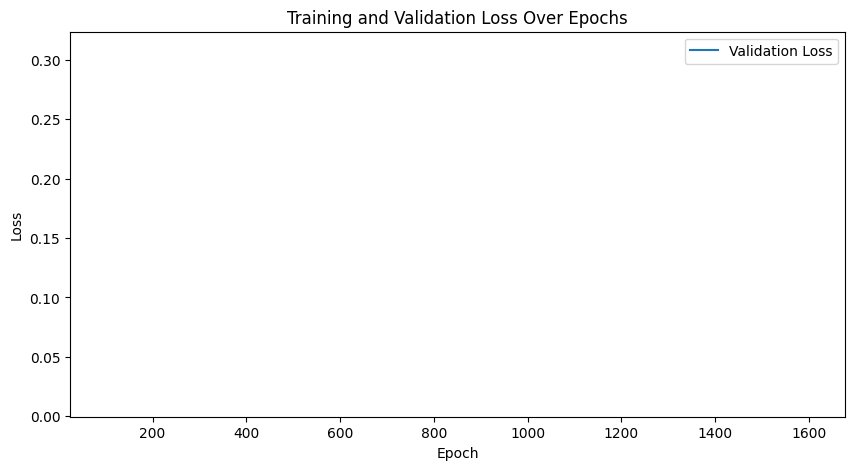

In [ ]:
# plot train_loss and valid_loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(result_df["train_loss"], label="Train Loss")
plt.plot(result_df["valid_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()